# PySpark Cluster Analysis on Weather Data

## HPC and Data Science Summer Institute

Mai H. Nguyen, UC San Diego

---
Resources:
- Spark DataFrame Guide: https://spark.apache.org/docs/latest/sql-programming-guide.html
- PySpark API Documentation: https://spark.apache.org/docs/latest/api/python/index.html
- PySpark Cheat Sheet PDF

## Setup 

In [1]:
# Start Spark session
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.SparkConf().setAll([('spark.master', 'local[2]'),
                                   ('spark.app.name', 'PySpark Cluster Analysis')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version)
print (pyspark.version)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/08 01:49:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


3.2.1
<module 'pyspark.version' from '/opt/spark/3.2.1/hadoop/3.2/python/lib/pyspark.zip/pyspark/version.py'>


In [2]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd

# Show plots in notebook
%matplotlib inline

## Read in data

Data source:  http://hpwren.ucsd.edu

In [3]:
from pyspark.sql.types import StructType, StructField 
from pyspark.sql.types import StringType, IntegerType, DoubleType, TimestampType

# Specify schema
schema = StructType ([ \
    StructField ("rowID",IntegerType(),True), \
    StructField ("hpwren_timestamp",TimestampType(),True), \
    StructField ("air_pressure",DoubleType(),True), \
    StructField ("air_temp",DoubleType(),True), \
    StructField ("avg_wind_direction",DoubleType(),True), \
    StructField ("avg_wind_speed",DoubleType(),True), \
    StructField ("max_wind_direction",DoubleType(),True), \
    StructField ("max_wind_speed",DoubleType(),True), \
    StructField ("min_wind_direction",DoubleType(),True), \
    StructField ("min_wind_speed",DoubleType(),True), \
    StructField ("rain_accumulation",DoubleType(),True), \
    StructField ("rain_duration",DoubleType(),True), \
    StructField ("relative_humidity",DoubleType(),True)
])

In [4]:
# Read in data and put in Spark DataFrame

from os.path import expanduser
HOME = expanduser("~")

data_path = HOME + '/data/'
inputfile = data_path + "minute_weather.csv"
print(inputfile)

df = spark.read.csv (inputfile, header=True, schema=schema).cache()

/home/train107/data/minute_weather.csv


## Explore data

### Print schema

In [5]:
df.printSchema()

root
 |-- rowID: integer (nullable = true)
 |-- hpwren_timestamp: timestamp (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- max_wind_direction: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- min_wind_direction: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- rain_accumulation: double (nullable = true)
 |-- rain_duration: double (nullable = true)
 |-- relative_humidity: double (nullable = true)



### Count rows

In [6]:
df.count()

1587257

### Show summary statistics

In [7]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,1587257,793628.0,458201.7724491034,0,1587256
air_pressure,1587257,916.8301266904355,3.0515931266797334,905.0,929.5
air_temp,1587257,61.85144042833238,11.833623786835483,31.64,99.5
avg_wind_direction,1586824,161.96537927331576,95.20811970204007,0.0,359.0
avg_wind_speed,1586824,2.774272067979729,2.060757793563034,0.0,32.3
max_wind_direction,1586824,163.40304784903682,92.3672342806411,0.0,359.0
max_wind_speed,1586824,3.3998134008569094,2.4231674336171545,0.1,36.0
min_wind_direction,1586824,166.82637078844283,97.4627462007766,0.0,359.0
min_wind_speed,1586824,2.1331304542923206,1.7453450849327021,0.0,32.0


## Prepare data

### Drop nulls

In [8]:
workingDF = df.na.drop()
workingDF.count()

1586823

### Create feature vector

In [9]:
from pyspark.ml.feature import VectorAssembler

featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [10]:
assembled.show(1)

+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+
|rowID|   hpwren_timestamp|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|rain_accumulation|rain_duration|relative_humidity|   features_unscaled|
+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+
|    1|2011-09-10 00:01:49|       912.3|   63.86|             161.0|           0.8|             215.0|           1.5|              43.0|           0.2|              0.0|          0.0|             39.9|[912.3,63.86,161....|
+-----+-------------------+------------+--------+------------------+--------------+------------------+------

### Scale data

In [11]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [12]:
scaledData.show(1)

+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+--------------------+
|rowID|   hpwren_timestamp|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|rain_accumulation|rain_duration|relative_humidity|   features_unscaled|            features|
+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+--------------------+--------------------+
|    1|2011-09-10 00:01:49|       912.3|   63.86|             161.0|           0.8|             215.0|           1.5|              43.0|           0.2|              0.0|          0.0|             39.9|[912.3,63.86,161....|[-1.4845928293047...|
+-----+-----------------

## Perform cluster analysis

### Generate elbow plot to determine value(s) for k

Trying k from 5 to 14 with 79342 samples

Training for cluster size 5 
......................WSSE = 251270.73495880482 
Training for cluster size 6 
......................WSSE = 235860.26012731568 
Training for cluster size 7 
......................WSSE = 219844.6094615158 
Training for cluster size 8 
......................WSSE = 197769.01209105825 
Training for cluster size 9 
......................WSSE = 189753.56673733064 
Training for cluster size 10 
......................WSSE = 175690.9243255231 
Training for cluster size 11 
......................WSSE = 164121.03683513874 
Training for cluster size 12 
......................WSSE = 161311.95874428097 
Training for cluster size 13 
......................WSSE = 152972.76868901472 
Training for cluster size 14 
......................WSSE = 147544.86191592074 
CPU times: user 117 ms, sys: 50.3 ms, total: 167 ms
Wall time: 19 s


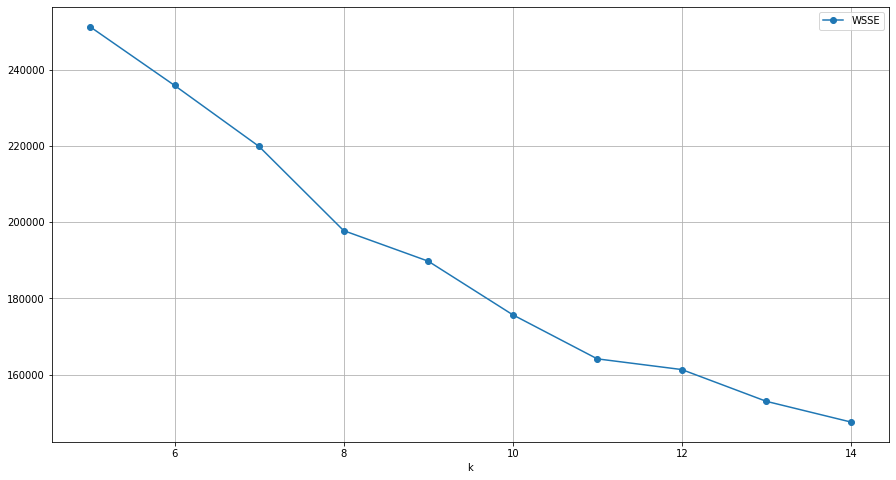

In [13]:
%%time
import utils

# Only need to run this once to find value(s) to try for k
# Set to False if already know value for k
create_elbow_plot = True 

# Get elbow plot using subset of data
if create_elbow_plot == True:
    sampledData = scaledData.filter((scaledData.rowID % 20) == 0).select("features").cache() 
    k_attempts = range(5,15)
    print('Trying k from {} to {} with {} samples\n'.format(list(k_attempts)[0],
                                                          list(k_attempts)[-1], 
                                                          sampledData.count()))
    wsseList = utils.elbow(sampledData, k_attempts)
    utils.elbow_plot(wsseList, k_attempts)

### Perform Clustering Using K-Means 

In [14]:
scaledData.printSchema()

root
 |-- rowID: integer (nullable = true)
 |-- hpwren_timestamp: timestamp (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- max_wind_direction: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- min_wind_direction: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- rain_accumulation: double (nullable = true)
 |-- rain_duration: double (nullable = true)
 |-- relative_humidity: double (nullable = true)
 |-- features_unscaled: vector (nullable = true)
 |-- features: vector (nullable = true)



In [15]:
from pyspark.ml.clustering import KMeans

scaledDataFeat = scaledData.select("features").cache()

# Set number of clusters
nClusters = 11

kmeans = KMeans(k=nClusters, seed=1)
model = kmeans.fit(scaledDataFeat)

In [16]:
# Show cluster centers

centers = model.clusterCenters()
pd.DataFrame(centers,columns=featuresUsed)

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,1.171256,-0.251789,-1.154951,2.166273,-1.054745,2.289235,-1.134940
1,0.463010,-0.944084,0.752266,-0.534278,0.665727,-0.513820,1.030146
2,0.327127,-1.015366,-1.211716,-0.573832,-1.046480,-0.582451,0.945063
3,-1.117210,-0.900354,0.441681,1.869681,0.534087,1.828972,0.945397
4,-0.214792,0.610966,0.411501,0.616994,0.501985,0.562956,-0.167618
5,-0.898883,-1.109780,0.384500,0.087716,0.463018,0.083325,1.331430
6,0.133075,0.947372,-1.334976,-0.571825,-1.182443,-0.580240,-0.870452
7,-0.071531,0.662120,0.538240,-0.656654,-0.002678,-0.656781,-0.532039
8,0.222609,0.792225,1.328018,-0.639614,1.599720,-0.590233,-0.715729
9,-0.652842,0.288582,-1.113623,-0.605836,-0.978505,-0.631862,0.103645


In [17]:
# Show cluster sizes

model.summary.clusterSizes

[74856,
 162242,
 89804,
 120564,
 215438,
 166702,
 152800,
 253180,
 131530,
 100447,
 119260]

## Generate cluster profile plots

In [18]:
centersNamed = utils.pd_centers(featuresUsed,centers)
print(centersNamed.columns.values)

['air_pressure' 'air_temp' 'avg_wind_direction' 'avg_wind_speed'
 'max_wind_direction' 'max_wind_speed' 'relative_humidity' 'prediction']


### Profiles for All Clusters

This is a parallel plot to show the cluster centers for all clusters.  
Data samples were standardized to have 0-mean and 1-standard-deviation before k-means was applied, so values of cluster centers can be interpreted as standard deviations from the mean.  

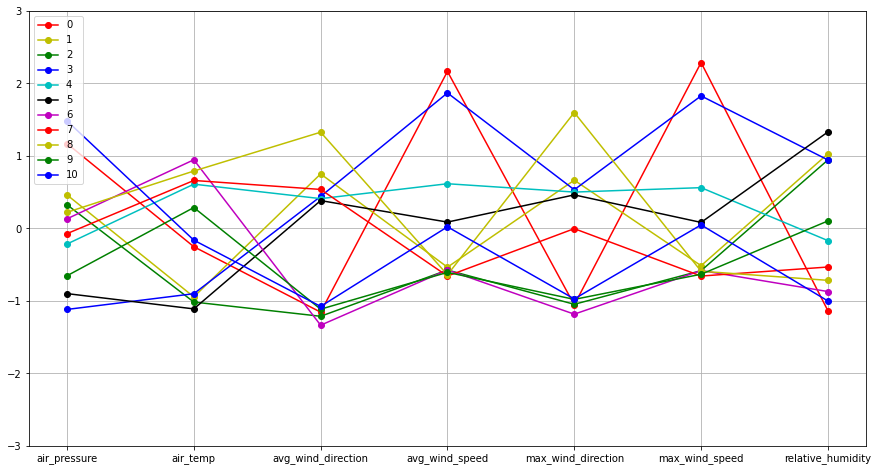

In [19]:
numClusters = len(centersNamed.index)
colors_used = utils.parallel_plot(centersNamed, numClusters)

### Clusters Capturing Dry Days

Clusters with lower-than-average relative_humidity values capture dry days

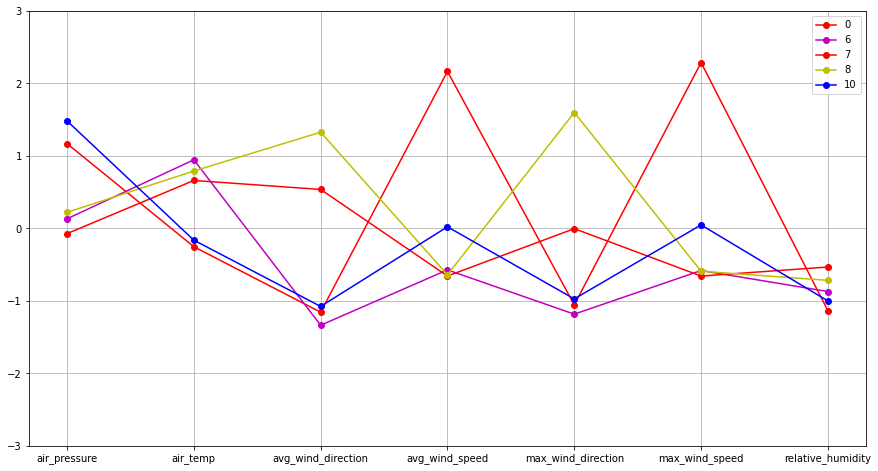

In [20]:
utils.parallel_plot(centersNamed[centersNamed['relative_humidity'] < -0.5], 
                   numClusters, colors=colors_used);

### Clusters Capturing Humid Days

Clusters with higher-than-average relative_humidity values capture humid days

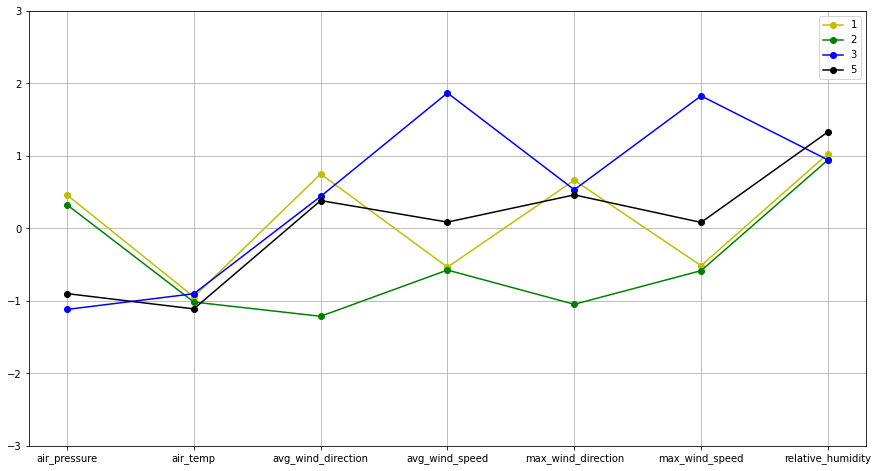

In [21]:
utils.parallel_plot(centersNamed[centersNamed['relative_humidity'] > 0.5], 
                    numClusters, colors=colors_used);

### Clusters Capturing Hot Days

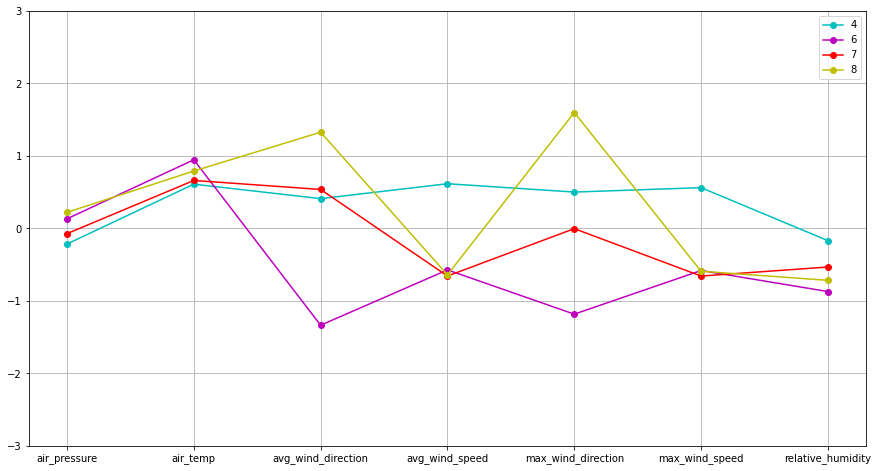

In [22]:
utils.parallel_plot(centersNamed[centersNamed['air_temp'] > 0.5], 
                   numClusters, colors=colors_used);

### Clusters Capturing Windy Days

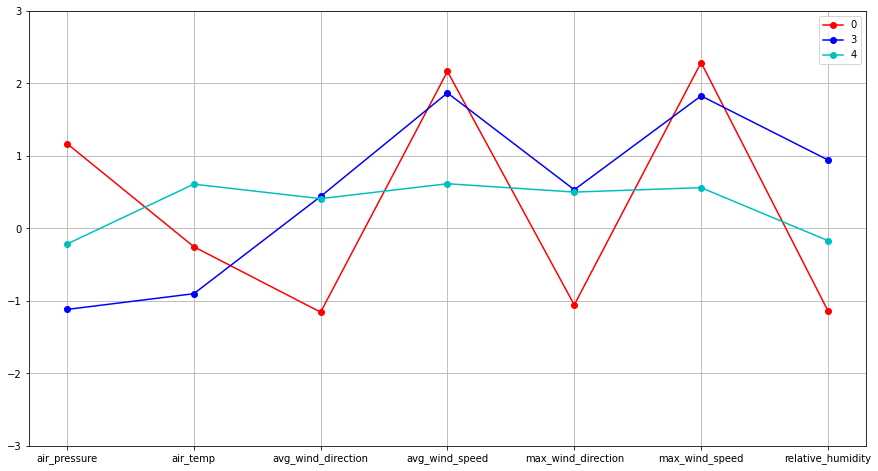

In [23]:
utils.parallel_plot(centersNamed[centersNamed['max_wind_speed'] > 0.5], 
                   numClusters, colors=colors_used);

## Save Model

In [24]:
model.write().overwrite().save("weather-kmeans-model")

## Stop Spark session

In [25]:
spark.stop()